# Electric Vehicle Energy Consumption Prediction 

In [1]:
!python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 1.3 MB/s eta 0:00:02
   - -------------------------------------- 0.1/1.8 MB 656.4 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.8 MB 1.1 MB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.8 MB 1.4 MB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.8 MB 1.4 MB/s eta 0:00:02
   ---------- ----------------------------- 0.5/1.8 MB 1.8 MB/s eta 0:00:01
   ----------- ---------------------------- 0.5/1.8 MB 1.7 MB/s eta 0:00:01
   --------------- ------------------------ 0.7/1.8 MB 2.0 MB/s eta 0:00:01
   ----------------- ---------------------- 0.8/1.8 MB 1.9 MB/s eta 0:00:01
   -------------------- ------------------- 0.9/1.8 MB 2.1 MB/s eta 0:00:01
   ---------------------- ----------------- 1.0/1.8 MB 2.0 MB/s eta 0:00:01
   -------------------------- ------------- 1.2/1.8 MB 2.2 MB/s eta 0:00:01
   --------------

In [2]:
!pip install --user statsmodels

In [4]:
import pandas as pd
from datetime import datetime
from dateutil.parser import parse
import numpy as np 
import seaborn as snsa
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sms 

# Data Preprocessing

In [19]:
df = pd.read_csv('Data.csv')

In [20]:
def parse_datetime(date_str):
    if isinstance(date_str, pd.Timestamp):
        return date_str
    try:
    
        return parse(date_str, fuzzy=True)
    except ValueError:
        return None 

In [21]:
df['Start_Date___Time'] = df['Start_Date___Time'].apply(parse_datetime)

In [22]:
df['End_Date___Time'].fillna(pd.Timestamp('1900-01-01'), inplace=True)

In [23]:
df['End_Date___Time'] = df['End_Date___Time'].apply(parse_datetime)

In [24]:
print(df['Start_Date___Time'].dtype)
print(df['End_Date___Time'].dtype)

datetime64[ns]
datetime64[ns]


In [11]:
print(df.head())

             Station_Name           Address     City State_Province  \
0  BOULDER / JUNCTION ST1  2280 Junction Pl  Boulder       Colorado   
1  BOULDER / JUNCTION ST1  2280 Junction Pl  Boulder       Colorado   
2  BOULDER / JUNCTION ST1  2280 Junction Pl  Boulder       Colorado   
3    BOULDER / ALPINE ST1   1275 Alpine Ave  Boulder       Colorado   
4  BOULDER / BASELINE ST1   900 Baseline Rd  Boulder       Colorado   

   Zip_Postal_Code   Start_Date___Time Start_Time_Zone     End_Date___Time  \
0            80301 2018-01-01 17:49:00             MDT 2018-01-01 19:52:00   
1            80301 2018-01-02 08:52:00             MDT 2018-01-02 09:16:00   
2            80301 2018-01-02 21:11:00             MDT 2018-01-03 06:23:00   
3            80304 2018-01-03 09:19:00             MDT 2018-01-03 11:14:00   
4            80302 2018-01-03 14:13:00             MDT 2018-01-03 14:30:00   

  End_Time_Zone Total_Duration__hh_mm_ss_ Charging_Time__hh_mm_ss_  \
0           MDT                   

In [12]:
pd.isnull(df).sum()

Station_Name                  0
Address                       0
City                          0
State_Province                0
Zip_Postal_Code               0
Start_Date___Time             0
Start_Time_Zone               0
End_Date___Time               0
End_Time_Zone                 0
Total_Duration__hh_mm_ss_     0
Charging_Time__hh_mm_ss_      0
Energy__kWh_                  0
GHG_Savings__kg_              0
Gasoline_Savings__gallons_    0
Port_Type                     0
ObjectID                      0
ObjectId2                     0
dtype: int64

In [14]:
df.head()

,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,End_Time_Zone,Total_Duration__hh_mm_ss_,Charging_Time__hh_mm_ss_,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,Port_Type,ObjectID,ObjectId2
0,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,2018-01-01 17:49:00,MDT,2018-01-01 19:52:00,MDT,2:03:02,2:02:44,6.504,2.732,0.816,Level 2,0,1
1,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,2018-01-02 08:52:00,MDT,2018-01-02 09:16:00,MDT,0:24:34,0:24:19,2.481,1.042,0.311,Level 2,1,2
2,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,2018-01-02 21:11:00,MDT,2018-01-03 06:23:00,MDT,9:12:21,3:40:52,15.046,6.319,1.888,Level 2,2,3
3,BOULDER / ALPINE ST1,1275 Alpine Ave,Boulder,Colorado,80304,2018-01-03 09:19:00,MDT,2018-01-03 11:14:00,MDT,1:54:51,1:54:29,6.947,2.918,0.872,Level 2,3,4
4,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018-01-03 14:13:00,MDT,2018-01-03 14:30:00,MDT,0:16:58,0:16:44,1.800,0.756,0.226,Level 2,4,5


In [13]:
df.tail(5)

,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,End_Time_Zone,Total_Duration__hh_mm_ss_,Charging_Time__hh_mm_ss_,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,Port_Type,ObjectID,ObjectId2
148131,BOULDER / N BOULDER REC 1,3172 Broadway,Boulder,Colorado,80304,2023-11-30 19:58:00,MST,2023-11-30 20:10:00,MST,0:12:13,0:11:42,1.194,0.848,0.150,Level 2,77937,148132
148132,BOULDER / CARPENTER PARK1,1505 30th St,Boulder,Colorado,80303,2023-11-30 20:00:00,MST,2023-11-30 20:01:00,MST,0:01:07,0:00:00,0.000,0.000,0.000,Level 2,77938,148133
148133,BOULDER / CARPENTER PARK1,1505 30th St,Boulder,Colorado,80303,2023-11-30 20:01:00,MST,2023-11-30 20:21:00,MST,0:19:52,0:19:43,1.899,1.349,0.238,Level 2,77939,148134
148134,BOULDER / REC CENTER ST2,1360 Gillaspie Dr,Boulder,Colorado,80305,2023-11-30 21:03:00,MST,2023-11-30 21:31:00,MST,0:28:08,0:27:50,1.499,1.064,0.188,Level 2,77940,148135
148135,BOULDER / FACILITIES ST1,1745 14th street,Boulder,Colorado,80302,2023-11-30 23:27:00,MST,2023-12-01 09:02:00,MST,9:35:17,3:50:19,17.755,12.606,2.228,Level 2,77941,148136


Start_Date___Time
2018-01-31    2543.954
2018-02-28    4693.882
2018-03-31    5150.894
2018-04-30    6530.386
2018-05-31    8520.862
Freq: ME, Name: Energy__kWh_, dtype: float64


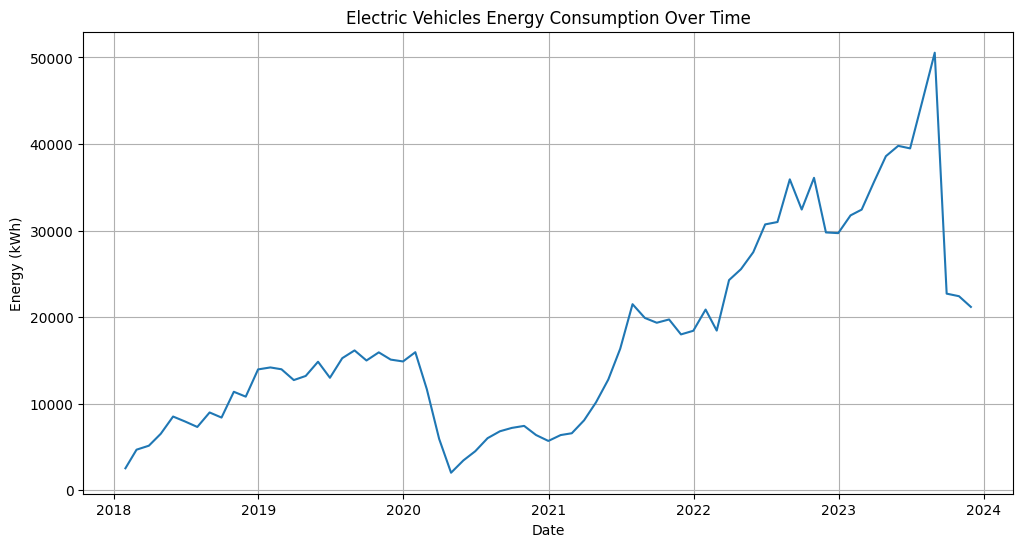

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Assuming df is your DataFrame containing the relevant columns
# Set 'Start_Date___Time' as datetime index
df['Start_Date___Time'] = pd.to_datetime(df['Start_Date___Time'])
df.set_index('Start_Date___Time', inplace=True)

# Selecting 'Energy__kWh_' for modeling
energy_data = df['Energy__kWh_'].resample('M').sum()  # Resample to monthly sum if needed

# Check the first few rows to ensure everything looks good
print(energy_data.head())

# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(energy_data)
plt.title('Electric Vehicles Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.show()


# USSU

# ARIMA Model

ARIMA Energy

In [15]:
# Function to perform ADF test
def adf_test(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Perform ADF test on energy_data
adf_test(energy_data)


Results of Augmented Dickey-Fuller Test:
Test Statistic                 -1.808773
p-value                         0.376115
#Lags Used                      0.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [16]:
# Apply differencing (d=1)
energy_data_diff = energy_data.diff().dropna()

# Perform ADF test on differenced data to confirm stationarity
adf_test(energy_data_diff)


Results of Augmented Dickey-Fuller Test:
Test Statistic                -8.910700e+00
p-value                        1.106364e-14
#Lags Used                     0.000000e+00
Number of Observations Used    6.900000e+01
Critical Value (1%)           -3.528890e+00
Critical Value (5%)           -2.904440e+00
Critical Value (10%)          -2.589656e+00
dtype: float64


In [17]:
# ARIMA model parameters (p, d, q)
p = 1  # Example value, can be determined from ACF/PACF plots
d = 0 # Since we applied differencing, d=0 for the differenced series
q = 1  # Example value, can be determined from ACF/PACF plots

# Fit the ARIMA model on the original data (since it's now stationary)
model_energy = ARIMA(energy_data, order=(p, d, q))
results_energy = model_energy.fit()

# Generate forecasts for the next 12 months (assuming monthly frequency)
forecast_steps = 12
forecast_energy = results_energy.forecast(steps=forecast_steps)

# Print the forecasted values
print("Forecasted Energy Consumption (next 12 months):")
print(forecast_energy)


Forecasted Energy Consumption (next 12 months):
2023-12-31    21013.348033
2024-01-31    20806.793789
2024-02-29    20612.901900
2024-03-31    20430.896128
2024-04-30    20260.047820
2024-05-31    20099.672993
2024-06-30    19949.129593
2024-07-31    19807.814926
2024-08-31    19675.163244
2024-09-30    19550.643483
2024-10-31    19433.757132
2024-11-30    19324.036242
Freq: ME, Name: predicted_mean, dtype: float64


ARIMA GASOLINE

In [25]:
# Assuming df is your DataFrame containing the relevant columns
# Set 'Start_Date___Time' as datetime index
df['Start_Date___Time'] = pd.to_datetime(df['Start_Date___Time'])
df.set_index('Start_Date___Time', inplace=True)

# Selecting 'GHG_Savings__kg_' and 'Gasoline_Savings__gallons_' for modeling
ghg_data = df['GHG_Savings__kg_'].resample('M').sum()  # Resample to monthly sum if needed
gasoline_data = df['Gasoline_Savings__gallons_'].resample('M').sum()  # Resample to monthly sum if needed

# Function to perform ADF test
def adf_test(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Perform ADF test on GHG_Savings__kg_
print("ADF Test for GHG_Savings__kg_:")
adf_test(ghg_data)

# Perform ADF test on Gasoline_Savings__gallons_
print("\nADF Test for Gasoline_Savings__gallons_:")
adf_test(gasoline_data)


ADF Test for GHG_Savings__kg_:
Results of Augmented Dickey-Fuller Test:
Test Statistic                 -1.713245
p-value                         0.424301
#Lags Used                     10.000000
Number of Observations Used    60.000000
Critical Value (1%)            -3.544369
Critical Value (5%)            -2.911073
Critical Value (10%)           -2.593190
dtype: float64

ADF Test for Gasoline_Savings__gallons_:
Results of Augmented Dickey-Fuller Test:
Test Statistic                 -1.808774
p-value                         0.376114
#Lags Used                      0.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [26]:
df.columns

Index(['Station_Name', 'Address', 'City', 'State_Province', 'Zip_Postal_Code',
       'Start_Time_Zone', 'End_Date___Time', 'End_Time_Zone',
       'Total_Duration__hh_mm_ss_', 'Charging_Time__hh_mm_ss_', 'Energy__kWh_',
       'GHG_Savings__kg_', 'Gasoline_Savings__gallons_', 'Port_Type',
       'ObjectID', 'ObjectId2'],
      dtype='object')

In [27]:
# Example of differencing
ghg_data_diff = ghg_data.diff().dropna()
gasoline_data_diff = gasoline_data.diff().dropna()


In [28]:
# Perform ADF test for differenced series
print("\nADF Test for Gasoline_Savings__gallons_ (after differencing):")
adf_test(gasoline_data_diff)



ADF Test for Gasoline_Savings__gallons_ (after differencing):
Results of Augmented Dickey-Fuller Test:
Test Statistic                -8.910791e+00
p-value                        1.105777e-14
#Lags Used                     0.000000e+00
Number of Observations Used    6.900000e+01
Critical Value (1%)           -3.528890e+00
Critical Value (5%)           -2.904440e+00
Critical Value (10%)          -2.589656e+00
dtype: float64


In [29]:
# Import necessary libraries
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model parameters
p = 1  # Example parameter (adjust based on ACF/PACF analysis)
d = 0  # Since the series is stationary after differencing
q = 1  # Example parameter (adjust based on ACF/PACF analysis)

# Fit ARIMA model
model_gasoline = ARIMA(gasoline_data, order=(p, d, q))
results_gasoline = model_gasoline.fit()

# Forecast next 12 months
forecast_steps = 12
forecast_gasoline = results_gasoline.forecast(steps=forecast_steps)

# Print forecasted values
print("\nForecasted Gasoline Savings (next 12 months):")
print(forecast_gasoline)



Forecasted Gasoline Savings (next 12 months):
2023-12-31    2637.190706
2024-01-31    2611.263753
2024-02-29    2586.926413
2024-03-31    2564.081225
2024-04-30    2542.636702
2024-05-31    2522.506969
2024-06-30    2503.611415
2024-07-31    2485.874369
2024-08-31    2469.224803
2024-09-30    2453.596042
2024-10-31    2438.925499
2024-11-30    2425.154424
Freq: ME, Name: predicted_mean, dtype: float64


ARIMA GHG

In [30]:
# Perform ADF test to check stationarity for GHG_Savings__kg_
adf_result_ghg = adfuller(ghg_data)
print("ADF Test for GHG_Savings__kg_:")
print(f"Test Statistic: {adf_result_ghg[0]}")
print(f"p-value: {adf_result_ghg[1]}")
print(f"#Lags Used: {adf_result_ghg[2]}")
print(f"Number of Observations Used: {adf_result_ghg[3]}")
print("Critical Values:")
for key, value in adf_result_ghg[4].items():
    print(f"{key}: {value}")

# If necessary, apply differencing or other transformations
# Example:
# ghg_data_diff = ghg_data.diff().dropna()

# Fit ARIMA model
# Example:
# p = 1  # Example parameter (adjust based on ACF/PACF analysis)
# d = 1  # Example parameter (adjust if differencing is needed)
# q = 1  # Example parameter (adjust based on ACF/PACF analysis)
# model_ghg = ARIMA(ghg_data, order=(p, d, q))
# results_ghg = model_ghg.fit()

# Forecast next 12 months
# forecast_steps = 12
# forecast_ghg = results_ghg.forecast(steps=forecast_steps)

# Print forecasted values
# print("\nForecasted GHG Savings (next 12 months):")
# print(forecast_ghg)


ADF Test for GHG_Savings__kg_:
Test Statistic: -1.713245002832173
p-value: 0.42430149753133173
#Lags Used: 10
Number of Observations Used: 60
Critical Values:
1%: -3.5443688564814813
5%: -2.9110731481481484
10%: -2.5931902777777776


In [31]:
# Example: Assuming ghg_data is your GHG_Savings__kg_ series
ghg_data_diff = ghg_data.diff().dropna()

# Perform ADF test on the differenced data
adf_result_ghg_diff = adfuller(ghg_data_diff)
print("ADF Test for GHG_Savings__kg_ (after differencing):")
print(f"Test Statistic: {adf_result_ghg_diff[0]}")
print(f"p-value: {adf_result_ghg_diff[1]}")
print(f"#Lags Used: {adf_result_ghg_diff[2]}")
print(f"Number of Observations Used: {adf_result_ghg_diff[3]}")
print("Critical Values:")
for key, value in adf_result_ghg_diff[4].items():
    print(f"{key}: {value}")

# Fit ARIMA model on the differenced data
# Example:
# p = 1  # Example parameter (adjust based on ACF/PACF analysis)
# d = 1  # Example parameter (since we applied first-order differencing)
# q = 1  # Example parameter (adjust based on ACF/PACF analysis)
# model_ghg_diff = ARIMA(ghg_data_diff, order=(p, d, q))
# results_ghg_diff = model_ghg_diff.fit()

# Forecast next 12 months
# forecast_steps = 12
# forecast_ghg_diff = results_ghg_diff.forecast(steps=forecast_steps)

# Print forecasted values
# print("\nForecasted GHG Savings (next 12 months):")
# print(forecast_ghg_diff)


ADF Test for GHG_Savings__kg_ (after differencing):
Test Statistic: -1.1611313483714456
p-value: 0.6900886781074204
#Lags Used: 9
Number of Observations Used: 60
Critical Values:
1%: -3.5443688564814813
5%: -2.9110731481481484
10%: -2.5931902777777776


In [32]:
# Example: Assuming ghg_data is your GHG_Savings__kg_ series
ghg_data_diff2 = ghg_data.diff().diff().dropna()

# Perform ADF test on the second-order differenced data
adf_result_ghg_diff2 = adfuller(ghg_data_diff2)
print("ADF Test for GHG_Savings__kg_ (after second-order differencing):")
print(f"Test Statistic: {adf_result_ghg_diff2[0]}")
print(f"p-value: {adf_result_ghg_diff2[1]}")
print(f"#Lags Used: {adf_result_ghg_diff2[2]}")
print(f"Number of Observations Used: {adf_result_ghg_diff2[3]}")
print("Critical Values:")
for key, value in adf_result_ghg_diff2[4].items():
    print(f"{key}: {value}")

# Adjust ARIMA parameters based on ACF/PACF analysis
# Example:
# p = 1  # Example parameter (adjust based on ACF/PACF analysis)
# d = 2  # Example parameter (since we applied second-order differencing)
# q = 1  # Example parameter (adjust based on ACF/PACF analysis)
# model_ghg_diff2 = ARIMA(ghg_data_diff2, order=(p, d, q))
# results_ghg_diff2 = model_ghg_diff2.fit()

# Forecast next 12 months
# forecast_steps = 12
# forecast_ghg_diff2 = results_ghg_diff2.forecast(steps=forecast_steps)

# Print forecasted values
# print("\nForecasted GHG Savings (next 12 months):")
# print(forecast_ghg_diff2)


ADF Test for GHG_Savings__kg_ (after second-order differencing):
Test Statistic: -5.7871198857403465
p-value: 4.969575066799794e-07
#Lags Used: 8
Number of Observations Used: 60
Critical Values:
1%: -3.5443688564814813
5%: -2.9110731481481484
10%: -2.5931902777777776


In [33]:
# Assuming ghg_data is your GHG_Savings__kg_ series
ghg_data_diff2 = ghg_data.diff().diff().dropna()

# Example ARIMA parameters (adjust based on ACF/PACF analysis)
p = 1  # Example parameter (adjust based on ACF/PACF analysis)
d = 2  # Since we applied second-order differencing
q = 1  # Example parameter (adjust based on ACF/PACF analysis)

# Fit ARIMA model
model_ghg_diff2 = ARIMA(ghg_data_diff2, order=(p, d, q))
results_ghg_diff2 = model_ghg_diff2.fit()

# Forecast next 12 months
forecast_steps = 12
forecast_ghg_diff2 = results_ghg_diff2.forecast(steps=forecast_steps)

# Print forecasted values
print("\nForecasted GHG Savings (next 12 months):")
print(forecast_ghg_diff2)



Forecasted GHG Savings (next 12 months):
2023-12-31    14747.146892
2024-01-31     3349.851150
2024-02-29    12130.221283
2024-03-31     5726.965633
2024-04-30    10749.337374
2024-05-31     7173.962889
2024-06-30    10068.363554
2024-07-31     8094.280154
2024-08-31     9783.714657
2024-09-30     8716.364246
2024-10-31     9723.485222
2024-11-30     9169.573448
Freq: ME, Name: predicted_mean, dtype: float64


# Accuracy

In [34]:
# Define the split point
train_size = len(energy_data) - 12
train_energy = energy_data[:train_size]
test_energy = energy_data[train_size:]

train_ghg = ghg_data[:train_size]
test_ghg = ghg_data[train_size:]

train_gasoline = gasoline_data[:train_size]
test_gasoline = gasoline_data[train_size:]


In [35]:
# Fit models
model_energy = ARIMA(train_energy, order=(p, d, q)).fit()
model_ghg = ARIMA(train_ghg, order=(p, d, q)).fit()
model_gasoline = ARIMA(train_gasoline, order=(p, d, q)).fit()


In [36]:
# Forecast
forecast_energy = model_energy.forecast(steps=12)
forecast_ghg = model_ghg.forecast(steps=12)
forecast_gasoline = model_gasoline.forecast(steps=12)


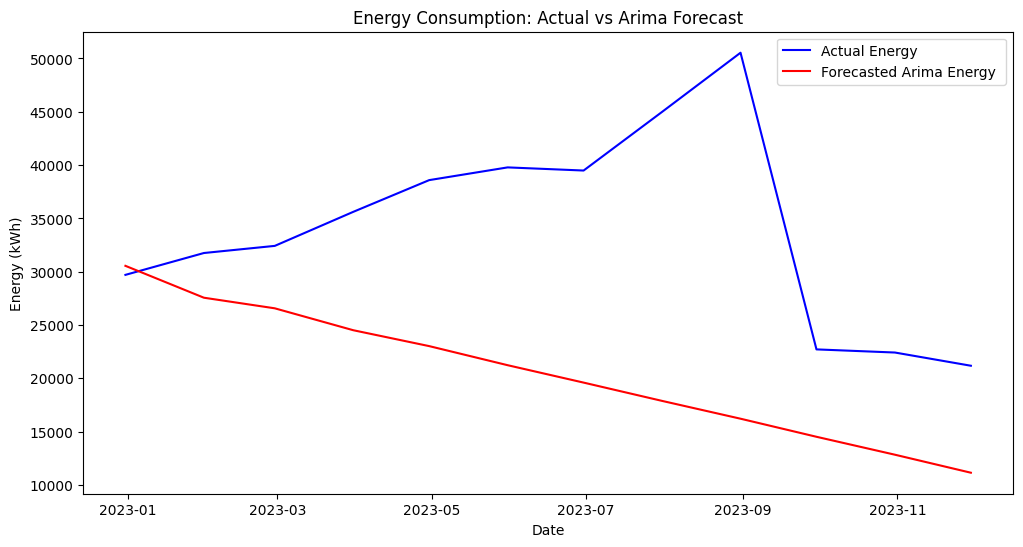

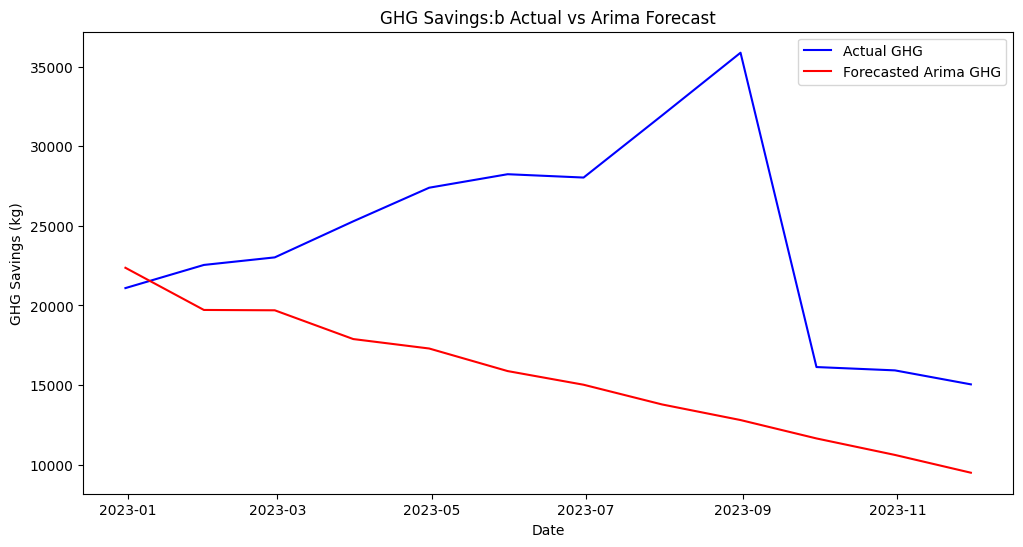

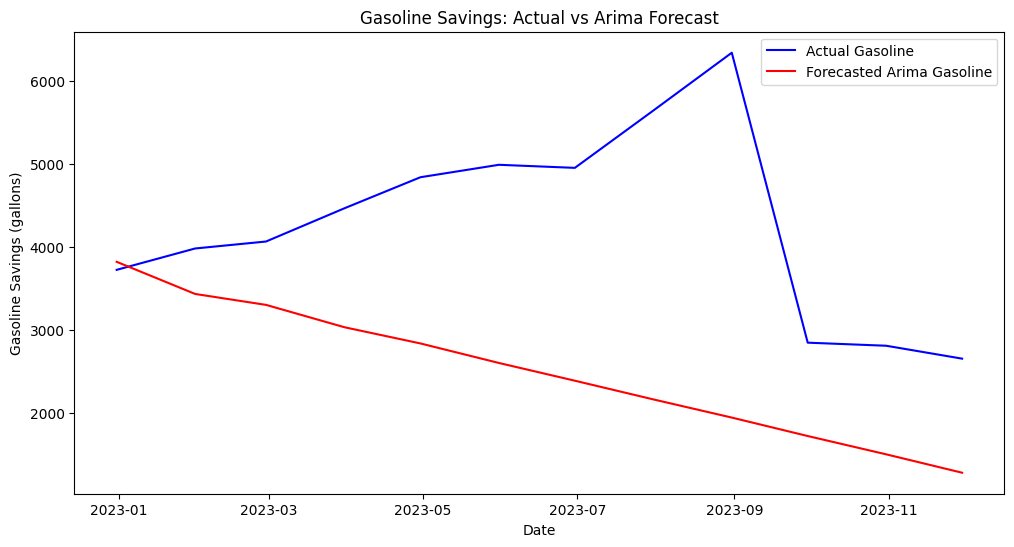

In [37]:
# Plotting Energy Forecast
plt.figure(figsize=(12, 6))
plt.plot(test_energy.index, test_energy, label='Actual Energy', color='blue')
plt.plot(test_energy.index, forecast_energy, label='Forecasted Arima Energy ', color='red')
plt.title('Energy Consumption: Actual vs Arima Forecast')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()

# Repeat for GHG and gasoline savings
# Plotting GHG Forecast
plt.figure(figsize=(12, 6))
plt.plot(test_ghg.index, test_ghg, label='Actual GHG', color='blue')
plt.plot(test_ghg.index, forecast_ghg, label='Forecasted Arima GHG', color='red')
plt.title('GHG Savings:b Actual vs Arima Forecast')
plt.xlabel('Date')
plt.ylabel('GHG Savings (kg)')
plt.legend()
plt.show()

# Plotting Gasoline Forecast
plt.figure(figsize=(12, 6))
plt.plot(test_gasoline.index, test_gasoline, label='Actual Gasoline', color='blue')
plt.plot(test_gasoline.index, forecast_gasoline, label='Forecasted Arima Gasoline', color='red')
plt.title('Gasoline Savings: Actual vs Arima Forecast')
plt.xlabel('Date')
plt.ylabel('Gasoline Savings (gallons)')
plt.legend()
plt.show()


# SARIMA Model

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the seasonal order
seasonal_order = (1, 1, 1, 24)  # Example seasonal parameters

# Fit the SARIMA model
model_energy = SARIMAX(train_energy, order=(p, d, q), seasonal_order=seasonal_order)
results_energy = model_energy.fit()

# Forecast
forecast_energy = results_energy.forecast(steps=24)

print("Forecasted Energy Consumption (next 12 months):")
print(forecast_energy)


Forecasted Energy Consumption (next 12 months):
2022-12-31    32025.147139
2023-01-31    32321.692712
2023-02-28    32218.458634
2023-03-31    31343.343132
2023-04-30    32072.937360
2023-05-31    33910.057767
2023-06-30    32728.541719
2023-07-31    35412.714345
2023-08-31    36097.839384
2023-09-30    35063.448928
2023-10-31    36021.478735
2023-11-30    35147.712589
2023-12-31    35080.736481
2024-01-31    36369.636875
2024-02-29    32312.896855
2024-03-31    27938.986828
2024-04-30    24652.225335
2024-05-31    26203.627422
2024-06-30    27612.916362
2024-07-31    29073.502915
2024-08-31    30418.056136
2024-09-30    30441.065597
2024-10-31    31119.480771
2024-11-30    29522.649004
Freq: ME, Name: predicted_mean, dtype: float64


In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the seasonal order
seasonal_order = (1, 1, 1, 14)  # Example seasonal parameters

# Fit the SARIMA model
model_gasoline = SARIMAX(train_gasoline, order=(p, d, q), seasonal_order=seasonal_order)
results_gasoline = model_gasoline.fit()

# Forecast
forecast_gasoline = results_gasoline.forecast(steps=14)

print("Forecasted Gasoline Consumption (next 12 months):")
print(forecast_gasoline)


Forecasted Gasoline Consumption (next 12 months):
2022-12-31    3769.984726
2023-01-31    3336.444256
2023-02-28    3157.508121
2023-03-31    2833.435780
2023-04-30    2502.213685
2023-05-31    2421.543826
2023-06-30    2264.660910
2023-07-31    2094.526748
2023-08-31    1963.716254
2023-09-30    1605.937077
2023-10-31    1497.026306
2023-11-30    1172.286046
2023-12-31    1028.199745
2024-01-31     511.339100
Freq: ME, Name: predicted_mean, dtype: float64


In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the seasonal order
seasonal_order = (1, 1, 1,15)  # Example seasonal parameters

# Fit the SARIMA model
model_ghg = SARIMAX(train_ghg, order=(p, d, q), seasonal_order=seasonal_order)
results_ghg = model_ghg.fit()

# Forecast
forecast_ghg = results_ghg.forecast(steps=15)

print("Forecasted Gasoline Consumption (next 12 months):")
print(forecast_ghg)


Forecasted Gasoline Consumption (next 12 months):
2022-12-31    22519.768480
2023-01-31    20501.935870
2023-02-28    20603.937106
2023-03-31    18978.602226
2023-04-30    19011.852579
2023-05-31    17311.514536
2023-06-30    17050.804248
2023-07-31    16440.716245
2023-08-31    16669.894554
2023-09-30    16582.530922
2023-10-31    16582.258461
2023-11-30    16845.753209
2023-12-31    16281.418402
2024-01-31    17332.428074
2024-02-29    14975.340754
Freq: ME, Name: predicted_mean, dtype: float64


<Figure size 1000x600 with 0 Axes>

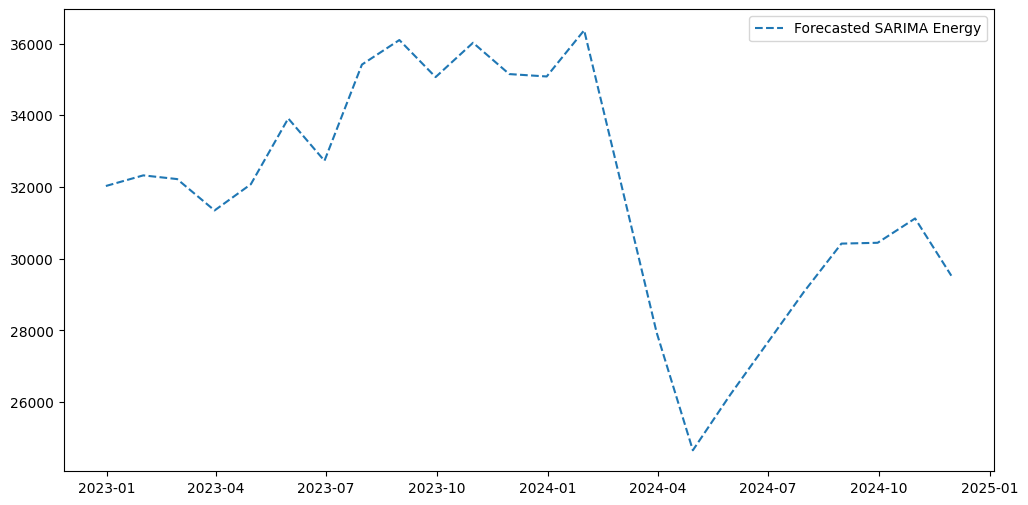

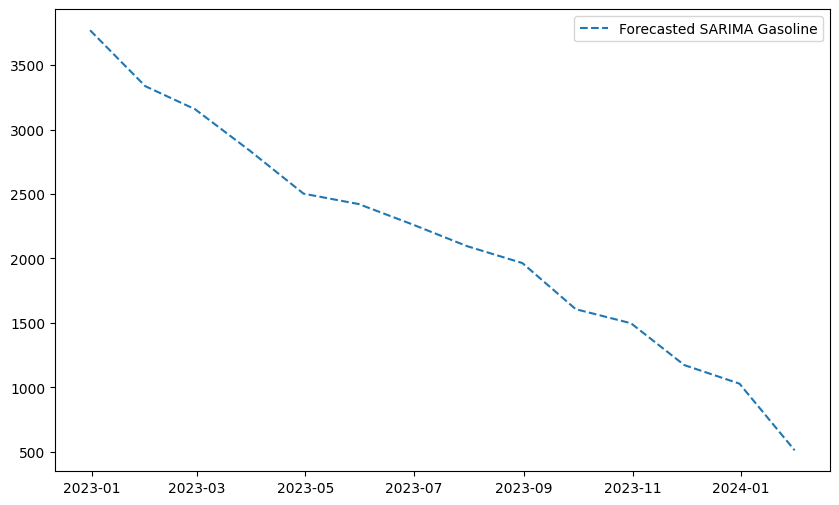

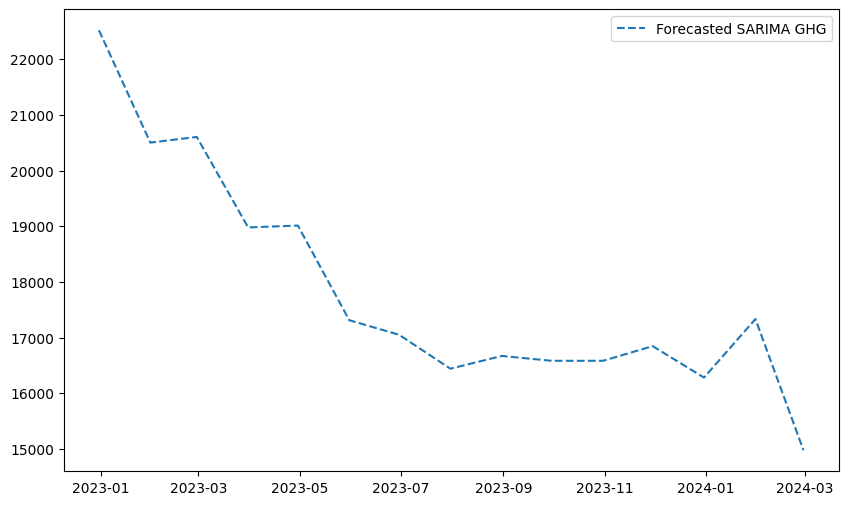

In [46]:
plt.figure(figsize=(10, 6))
# Plotting Energy Forecast
plt.figure(figsize=(12, 6))

# plt.plot(test_energy.index, test_energy, label='Actual Energy')
plt.plot(forecast_energy.index, forecast_energy, label='Forecasted SARIMA Energy', linestyle='--')
plt.legend()
plt.show()

#Gasoline
plt.figure(figsize=(10, 6))
plt.plot(forecast_gasoline.index, forecast_gasoline, label='Forecasted SARIMA Gasoline', linestyle='--')
plt.legend()
plt.show()

#GHG
plt.figure(figsize=(10, 6))
plt.plot(forecast_ghg.index, forecast_ghg, label='Forecasted SARIMA GHG', linestyle='--')
plt.legend()
plt.show()
